In [64]:
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
import numpy as np
import time

from astropy import units as u
from astropy.visualization import quantity_support
import astropy.coordinates as coord
quantity_support()

from libstarcam import (
    InterpolatableTable,
    Filter, Lens, Sensor, StarCamera,
    get_filter_transmission, get_optics_transmission,
    calc_limiting_mag,
    get_tycho_stars,
    get_median_Teff,
    get_model_flux_density,
    get_zero_point_flux, # in beta
    get_equivalent_mag, # in beta
    simple_snr_spectral
)

darksky = '#223355'

%matplotlib widget

Rapidly explore different combinations of sensors, lenses, and filters to build the optimal star camera.

In [65]:
lambd = np.arange(400, 1205, 5) * u.nm

# filter library
# Tycho2 V
lambd_dat, tau = np.genfromtxt('./TYCHO_TYCHO.V.dat', dtype=float, unpack=True)
lambd_dat = (lambd_dat * u.angstrom).to(u.nm)
F0 = (3.99504e-9 * u.erg / u.s / u.cm**2 / u.angstrom).to(u.W / u.cm**2 / u.um)
tycho_v = Filter(F0, tau_table=InterpolatableTable(lambd_dat, tau, clamp_edges=True), name='Tycho V')

# A good initial guess
F0 = 1.2e-12 * u.W / (u.cm**2) / u.um # I-band, McLean 2008, Table 9.4

nofilter = Filter(F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=400*u.nm, width=7*u.nm, max_transmission=1.0)),
    cost=0.,
    name='no filter'
)
yellow480 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=480*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=73.,
    name='yellow480'
)
green530 = Filter(
    F0,
    tau_table=InterpolatableTable(
        np.array([400, 460, 480, 500, 530, 550, 580, 620, 670, 700, 800, 900, 1000, 1100, 1200]),
        np.array([0.0, 0.0, .02, .14, .54, .36, .08, 0.0, 0.0, .01, .02, .02, 0.03, 0.03, 0.03]), # extrapolating past 700 nm...
    ),
    cost=80.,
    name='green530'
) # Agena Astro #58A green https://agenaastro.com/media/images/58a_green.jpg
green520 = Filter(
    F0,
    tau_table=InterpolatableTable(
        np.array([400, 460, 480, 500, 530, 550, 580, 620, 650, 670, 700, 800, 900, 1000, 1100, 1200]),
        np.array([0.0, 0.0, .10, .54, .78, .72, .45, .14, .02, .10, .65, .70, .75, 0.78, 0.75, 0.70]), # actually just making stuff up past 700 nm
    ),
    cost=80.,
    name='green520'
) # Agena Astro green https://agenaastro.com/media/images/56_light_green.jpg
red600 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=600*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=73.,
    name='red600'
)
red610 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=610*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=73.,
    name='red610'
) # basically Wratten #29
red620 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=620*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=73.,
    name='red620'
)
red695 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=695*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=140.,
    name='red695'
)
black760 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=760*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=40.,
    name='black760'
)
black850 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=850*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=100.,
    name='black850'
) # https://www.bhphotovideo.com/c/product/1688039-REG/kolari_72mmk850_01_72mm_850nm_filter.html
black950 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=950*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=34.,
    name='black950'
)
interference1000 = Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=1000*u.nm, width=7*u.nm, max_transmission=0.9)),
    cost=130.,
    name='interference1000'
) # https://www.bhphotovideo.com/c/search?q=infrared%20filter%2072mm&sts=ma

assorted_filters = [red620, black760, black850, black950, interference1000]

 # helpful for testing things as a function of cutoff frequency
filter_array = [Filter(
    F0,
    tau_table=InterpolatableTable(lambd, get_filter_transmission(lambd, center=l, width=7*u.nm, max_transmission=0.9)),
    name=str(l.value)
) for l in lambd[::5]]

# lens library
# most prices are used market
# EF-mount lenses - Birger EF focuser compatible
canon_300_4 = Lens(
    300 * u.mm,
    300 * u.mm / 4,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 300mm f/4',
    cost=1200.
)
canon_300_28 = Lens(
    300 * u.mm,
    300 * u.mm / 2.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 300mm f/2.8',
    cost=1500.
)
canon_200_28 = Lens(
    200 * u.mm,
    200 * u.mm / 2.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/2.8',
    cost=443.
)
canon_200_2 = Lens(
    200 * u.mm,
    200 * u.mm / 2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/2',
    cost=2900.
)
canon_200_18 = Lens(
    200 * u.mm,
    200 * u.mm / 1.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 200mm f/1.8',
    cost=4000.
)
canon_135_2 = Lens(
    135 * u.mm,
    135 * u.mm / 2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 135mm f/2',
    cost=332.,
)
canon_85_12 = Lens(
    85 * u.mm,
    85 * u.mm / 1.2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 85mm f/1.2',
    cost=829.
)
canon_85_18 = Lens(
    85 * u.mm,
    85 * u.mm / 1.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 85mm f/1.8',
    cost=209.
)
canon_50_12 = Lens(
    50 * u.mm,
    50 * u.mm / 1.2,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Canon 50mm f/1.2',
    cost=650.
)
nikon_180_28 = Lens(
    180 * u.mm,
    180 * u.mm / 2.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Nikon Ai Nikkor 180mm f/2.8',
    cost=200.
)
olympus_150_2 = Lens(
    150 * u.mm,
    150 * u.mm / 2.,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Olympus 150mm f/2',
    cost=1500.
)
sigma_135_18 = Lens(
    135 * u.mm,
    135 * u.mm / 1.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Sigma 135mm f/1.8 DG HSM',
    cost=1399., # MSRP
)
# M12 screw-mount lenses - most raspberry pi MIPI camera modules
m12_50_28 = Lens(
    50 * u.mm,
    50 * u.mm / 2.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='IR CAM 50mm f/2.8',
    cost=30.
)
m12_35_185 = Lens(
    35 * u.mm,
    35 * u.mm / 1.85,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Edmund 35mm f/1.85',
    cost=250.
)
m12_25_17 = Lens(
    25 * u.mm,
    25 * u.mm / 1.7,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='IR CAM 25mm f/1.7',
    cost=30.
)
m12_75_28 = Lens(
    75 * u.mm,
    75 * u.mm / 1.8, # https://wiki.kurokesu.com/books/lenses/page/l147-75-m12
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Kurokesu 75mm f/1.8',
    cost=113.
) # https://www.kurokesu.com/shop/L147-75-M12
fuji_75_18 = Lens(
    75 * u.mm,
    75 * u.mm / 1.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Fuji 75mm f/1.8',
    cost=400.
)
konica_135_f4 = Lens(
    135 * u.mm,
    135 * u.mm / 4, # really f/3.2, but f/3.2 is very bad optically
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Konica Hexanon 135mm f/4',
    cost=400.
)
konica_57_f14 = Lens(
    57 * u.mm,
    57 * u.mm / 1.4,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Konica Hexanon 57mm f/1.4',
    cost=90.
)
hadley_900_78 = Lens(
    900 * u.mm,
    900 * u.mm / 7.8,
    InterpolatableTable(lambd, get_optics_transmission(lambd)),
    name='Hadley 114 Newt',
    cost=150.
)


# sensor library
ui_3260 = Sensor(
    (1936, 1216),
    5.86 * u.um,
    0.35/u.s, # http://neutronoptics.com/soft/Manual-NeutronOptics-FLIR-CMOS-Camera.pdf
    21,
    31800 * u.electron / u.pix,
    8,
    gain_adu_per_e=(1. / 140.8 / u.electron),
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        np.array([0.58, 0.77, 0.61, 0.5, 0.39, 0.29, 0.2, 0.03, 0.0, 0.0])
    ),
    cost=688.,
    name='iDS uEye UI-3260-CP-M-GL'
) # https://en.ids-imaging.com/store/ui-3260cp-rev-2.html
u3_31n0se = Sensor(
    (5328,3040),
    2.74*u.um,
    1.38/u.s, # https://thinklucid.com/product/triton-16-2-mp-imx542/?srsltid=AfmBOorWeS_UYDtT8ZuoNhhgyEVhc7NRxoBQiFOYLiM8PHZ1PaTqk6eL
    1, # https://www.ximea.com/products/usb-vision-industrial/xic-sony-cmos-pregius-usb3-cameras/sony-imx542-usb3-color-industrial-camera
    9465 * u.electron / u.pix,
    8, # real capability is 12-bit, but we might run in 8-bit for software reasons
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        np.array([0.62, 0.72, 0.6, 0.53, 0.43, 0.34, 0.24, 0.04, 0.0, 0.0])
    ),
    cost=1700.,
    name='iDS uEye U3-31N0SE-M-GL'
) # https://en.ids-imaging.com/store/u3-31n0se-rev-1-2.html
qimaging_retiga_exi = Sensor(
    (1360, 1020),
    6.8*u.um,
    15. / u.s, # typ, 25C
    20,
    45e3 * u.electron / u.pix, # typ
    12,
    qe_table=InterpolatableTable(
        np.array([300, 400, 500, 600, 650, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.0, 0.0, .35, .60, .61, .60, .40, .20, 0.05, 0.00, 0.00])
    ), # by eye, from datasheet, assumed no IR filter
    cost=1000., # used
    name='QImaging Retiga EXi'
) # QImaging datasheet doesn't quote match Dober's thesis...
kodak_kaf1401E = Sensor(
    (1312, 1024),
    6.8*u.um,
    15. / u.s, # typ, 25C
    15,
    45e3 * u.electron / u.pix, # typ
    12,
    qe_table=InterpolatableTable(
        np.array([300, 400, 500, 600, 650, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0., 0.3, 0.42, 0.61, 0.62, 0.53, 0.32, 0.21, 0.05, 0.0, 0.0])
    ), # assume the no-microlens model
    cost=10000.,
    name='Kodak KAF-1401E'
) # estimated from KAF-1402E/ME datasheet
kodak_kaf1603E = Sensor(
    (1536, 1024),
    9*u.um,
    50. / u.s, # max, 10 typ., @ 25 C
    15,
    100000 * u.electron / u.pix,
    14,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.3, 0.43, 0.57, 0.65, 0.54, 0.33, 0.22, 0.05, 0.0, 0.0])
    ), # assume the no-microlens model
    cost=10000.,
    name='Kodak KAF-1603E'
)
kodak_kaf1603ME = Sensor(
    (1530, 1020),
    9*u.um,
    50. / u.s, # max, 10 typ., @ 25 C
    15,
    100000 * u.electron / u.pix,
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.42, 0.52, 0.72, 0.8, 0.7, 0.49, 0.24, 0.05, 0.0, 0.0])
    ),
    cost=10000.,
    name='Kodak KAF-1603ME'
)
basler_acA2440_20gm = Sensor(
    (2448, 2048),
    3.45*u.um,
    4.57 / u.s, # max, 10 typ., @ 25 C
    2.15,
    10679 * u.electron / u.pix,
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        0.6729 * np.array([0.5, 0.85, 1.0, 0.96, 0.86, 0.56, 0.25, 0.06, 0.0, 0.0])
    ),
    cost=880.,
    name='Basler acA2440-20gm (IMX264)'
) # https://thinklucid.com/product/phoenix-5-mp-imx264/?srsltid=AfmBOopMw4Xj_SsJ7YZhVH03fBl6HkJi_XWMI77tFw8EnQxReV1lR5Kz
cis2051 = Sensor(
    (2560, 2160),
    6.5*u.um,
    25. / u.s, # typ, 25C
    2,
    35e3 * u.electron / u.pix, # max
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.22, 0.51, 0.55, 0.48, 0.3, 0.14, 0.05, 0.0, 0.0])
    ),
    cost=260., # secondhand
    name='Fairchild/BAE SciMOS 2051 F2'
) # https://datasheet.datasheetarchive.com/originals/crawler/fairchildimaging.com/9698e5338bf938351813aa24134bd169.pdf
ov9281 = Sensor(
    (1280,800),
    3*u.um,
    1/u.s, # not listed
    3.2,
    14000. * u.electron / u.pix, # not documented anywhere
    10,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        0.8 * np.array([0.50, 0.92, 1.0, 0.83, 0.56, 0.30, 0.08, 0.0, 0.0]) # relative curve only, assume peak 80%
    ),
    cost=30.,
    name='OV9281'
)
asi220mm = Sensor(
    (1920,1080),
    4*u.um,
    1/u.s, # not listed
    3.2,
    8.78e3 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.86, 0.92, 0.86, 0.75, 0.57, 0.38, 0.16, 0.0, 0.0])
    ),
    cost=249.,
    name='ZWO ASI220MM'
) # https://www.zwoastro.com/product/zwo-asi220mm-minimono/
asi183mm = Sensor(
    (5496,3672),
    2.4*u.um,
    1.56/u.s, # @30 C, also the max measured value
    1.6,
    15e3 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 650, 700, 750, 800, 1000, 1100, 1200]) * u.nm,
        0.84 * np.array([0.7, 0.96, 0.93, 0.8, 0.73, 0.45, 0.25, 0.09, 0.0, 0.0])
    ),
    cost=999.,
    name='ZWO ASI183MM'
) # https://www.zwoastro.com/product/asi183mm-mc/
asi178mm = Sensor( # hardware binning 2x
    (3096,2080),
    2.4*u.um,
    30/u.s, # unknown, choose something bad, doesn't matter
    2.3,
    15e3 * u.electron / u.pix,
    14,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.70, 0.92, 0.86, 0.72, 0.48, 0.25, 0.1, 0.0, 0.0])
    ), # https://astronomy-imaging-camera.com/product/asi178mm-mono/
    cost=699.,
    name='ZWO ASI178MM (IMX178)'
) # https://www.zwoastro.com/product/asi294mm-mc/
asi294mm = Sensor( # hardware binning 2x
    (4144,2822),
    4.64*u.um,
    0.185/u.s, # copied from qhy model below
    1.2,
    14.4e3 * u.electron / u.pix,
    14,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.64, 0.89, 0.86, 0.66, 0.44, 0.3, 0.1, 0.0, 0.0])
    ), # https://www.highpointscientific.com/media/wysiwyg/zwo-asi294mm-peak-qe_1.jpg
    cost=699.,
    name='ZWO ASI294MM (IMX492)'
) # https://www.zwoastro.com/product/asi294mm-mc/
qhy294m = Sensor(
    (4164,2796),
    4.63*u.um,
    0.185/u.s,
    6.34,
    15655 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.7489, 0.8555, 0.6699, 0.4069, 0.2478, 0.1048, 0.0036, 0.0, 0.0])
    ), # https://thinklucid.com/product/atlas10-47mp-imx492/?srsltid=AfmBOopZ_X-HADsVjUXdADE_B9aT_rG-wxSMF7FPXXMrn-KGeBVtj6wP
    cost=1299.,
    name='QHY294M (IMX492)'
) # https://www.qhyccd.com/astronomical-camera-qhy294/
qhy5iii585m = Sensor(
    (3856,2180),
    2.9*u.um,
    0.518/u.s, # @30 C, the max
    8.04,
    52e3 * u.electron / u.pix, # https://www.qhyccd.com/qhy5iii585/
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.91, 0.91, 0.88, 0.76, 0.58, 0.38, 0.16, 0.0, 0.0])
    ), # https://www.qhyccd.com/minicam8/
    cost=349.,
    name='QHY5III585M (IMX585)'
) # https://www.qhyccd.com/qhy5iii585/
qhy268 = Sensor(
    (6252,4176),
    3.76*u.um,
    0.0369/u.s, # @20 C, the max
    3.5,
    51e3 * u.electron / u.pix,
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.72, 0.90, 0.72, 0.46, 0.28, 0.15, 0.04, 0.0, 0.0])
    ), # https://www.qhyccd.com/astronomical-camera-qhy268/
    cost=2399.,
    name='QHY268M'
) # https://www.qhyccd.com/astronomical-camera-qhy268/
qhy533 = Sensor(
    (3008,3028),
    3.76*u.um,
    0.0005/u.s, # @-20 C, no other data/I'm lazy/doesn't matter
    3.4,
    58e3 * u.electron / u.pix,
    14,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.72, 0.90, 0.72, 0.46, 0.28, 0.15, 0.04, 0.0, 0.0])
    ), # https://www.qhyccd.com/astronomical-camera-qhy533/, same QE as 268?
    cost=1099.,
    name='QHY533M'
) # https://www.qhyccd.com/astronomical-camera-qhy533/
qhy183 = Sensor(
    (5544,3684),
    2.4*u.um,
    0.062/u.s, # @15 C, the max
    2.7,
    15.5e3 * u.electron / u.pix,
    16,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.74, 0.84, 0.65, 0.43, 0.24, 0.11, 0.04, 0.0, 0.0])
    ), # https://cloudbreakoptics.com/blogs/news/product-review-the-qhy-183c
    cost=999.,
    name='QHY183M (IMX183)'
) # https://www.qhyccd.com/astronomical-camera-qhy183/
sv705c = Sensor(
    (3586,2180),
    2.9*u.um,
    1/u.s, # @15 C, the max
    7,
    40e3 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        0.9 / 3. *  np.array([0.4, 0.85, 0.95, 0.92, 0.9, 0.65, 0.3, 0.1, 0.0])
    ),
    cost=249.,
    name='SVBONY SV705C (IMX585C)'
) # https://www.svbony.com/sv705c-color-planetary-camera-imx585/#F9198J
triton2_swir = Sensor(
    (2560, 2048),
    3.45*u.um,
    26800/u.s, # @ 49 C
    122, # https://www.qhyccd.com/scientific-camera-qhy990_qhy991_qhy992/
    52e3 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800]) * u.nm,
        np.array([0.61, 0.68, 0.68, 0.53, 0.56, 0.62, 0.68, 0.71, 0.745, 0.74, 0.74, 0.72, 0.69, 0.645, 0.08, 0.0])
    ), # https://www.axiomoptics.com/products/alvium-vswir-uncooled-ingaas-cameras/
    cost=20400.,
    name='Triton2 SWIR (IMX992)'
) # https://thinklucid.com/product/triton2-swir-5-2mp-model-imx992/
fuji_xtrans5 = Sensor(
    (7728, 5152),
    3.04*u.um,
    30. / u.s, # really hard to find this for non-Canon consumer sensors, assume something relatively bad because uncooled
    2.549, # https://www.photonstophotos.net/Charts/RN_e.htm
    17400 * u.electron / u.pix, # approx.: 2^14 * base ISO gain @ 1.064 e-/DN
    14,
    qe_table=InterpolatableTable(
        np.array([400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        np.array([0.04, 0.97, 0.97, 0.78, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0])
    ), # assume similar QE curve to xtrans 1: xpro1 https://kolarivision.com/articles/internal-cut-filter-transmission/
    cost=1600., # approx. price of the body
    name='Fujifilm X-T5'
)
flir_chameleon3 = Sensor(
    (1928, 1448),
    3.69*u.um,
    30. / u.s, # not stated, assume something bad
    10.48,
    10936 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 470, 525, 640, 850, 950, 1000, 1100, 1200]) * u.nm,
        np.array([.4, 0.51, 0.76, 0.48, 0.16, 0.05, 0., 0., 0.])
    ), # color CCD
    cost=65.,
    name='Sony ICX 818 CCD'
) # https://www.artisantg.com/info/FLIR_Systems_Point_Grey_Research_Grasshopper2_GS2_FW_14S5M_Datasheet3_202035174148.pdf?srsltid=AfmBOorqeIW711obV0XDVJKNebROna_C6JJCKDsIPU9VyK6o_VoxEt-k
rpi_hq = Sensor(
    (4056, 3040),
    1.55*u.um,
    30. / u.s, # unknown, pick something bad because small and uncooled
    3., # @ gain 1
    8180 * u.electron / u.pix,
    12,
    qe_table=InterpolatableTable(
        np.array([400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]) * u.nm,
        0.8 * np.array([0.3, 0.73, 0.96, 0.62, 0.3, 0.2, 0.3, 0.1, 0.0, 0.0])
    ), # https://drive.google.com/file/d/16kOW9guoNO0lmomHGOPPzdJGknL9HO1U/view?usp=sharing gives relative, assume peak of .8
    cost=50.,
    name='RPi HQ (IMX477)' # WARNING: "STAR-EATER" ALGORITHM SHOULD BE DISABLED
) # https://www.strollswithmydog.com/pi-hq-cam-sensor-performance/

In [66]:
# TIM star cameras
SC1 = StarCamera(ui_3260, canon_200_28, nofilter, name='SC1')
SC2 = StarCamera(ui_3260, canon_200_28, red620, name='SC2')
SC2_fast = StarCamera(ui_3260, canon_200_2, red620, name='SC2-fast')

# TIM candidate star cameras
tim_wide = StarCamera(ui_3260, canon_85_12, red620, name='TIM-wide')
tim_wide_green = StarCamera(ui_3260, canon_85_12, green530, name='TIM-wide-green')
tim_wide_cheap = StarCamera(ui_3260, canon_85_18, red620, name='TIM-wide-cheap')
tim_narrow = StarCamera(ui_3260, canon_300_4, red620, name='TIM-narrow')

tim_prime = StarCamera(u3_31n0se, canon_200_28, red620, name='tim-prime')
tim_prime_wide = StarCamera(u3_31n0se, canon_85_12, red620, name='tim-prime-wide')
tim_prime_wide_ish = StarCamera(u3_31n0se, canon_135_2, red620, name='time-prime-wide-ish')

cam_zwo178m = StarCamera(asi178mm, canon_200_28, red620, name='candidate-zwo178m')
cam_zwo183m = StarCamera(asi183mm, canon_200_28, red620, name='candidate-zwo183m')
cam_zwo294m = StarCamera(asi294mm, canon_200_28, red620, name='candidate-zwo294m')
cam_zwo294m_wide = StarCamera(asi294mm, canon_85_12, red620, name='candidate-zwo294m-wide')
cam_qhy294m = StarCamera(qhy294m, canon_200_28, red620, name='candidate-qhy294m')
cam_qhy5iii585m = StarCamera(qhy5iii585m, canon_200_28, red620, name='candidate-qhy5iii585m')
cam_qhy5iii585m_wide = StarCamera(qhy5iii585m, canon_85_12, red620, name='candidate-qhy5iii5m-wide')
cam_qhy268m = StarCamera(qhy268, canon_200_28, red620, name='candidate-qhy268m')
cam_qhy533m = StarCamera(qhy533, canon_200_28, red620, name='candidate-qhy533m')
cam_qhy183m = StarCamera(qhy183, canon_200_28, red620, name='candidate-qhy183m')

# cameras that have flown
hero = StarCamera(kodak_kaf1401E, nikon_180_28, red620, name='HERO')
daystar = StarCamera(cis2051, olympus_150_2, red610, name='DayStar')
spider = StarCamera(kodak_kaf1603ME, canon_200_28, red600, name='SPIDER')
ebex = StarCamera(kodak_kaf1603E, canon_200_18, red620, name='EBEX') # ebex doesn't mention a filter, but STARS worked so give them benefit of the doubt, red620
superbit = StarCamera(basler_acA2440_20gm, canon_300_4, red620, name='SuperBIT')
blast_tng_isc = StarCamera(qimaging_retiga_exi, canon_200_2, red620, name='BLAST-TNG') # actually a Nikon, but 200mm f/2
# wasp

# SWIR options
cam_swir = StarCamera(triton2_swir, canon_135_2, black850, name='swir')
cam_swir_wide = StarCamera(triton2_swir, canon_85_12, black850, name='swir-wide')
cam_swir_ultrawide = StarCamera(triton2_swir, canon_50_12, black850, name='swir-ultrawide')

# for fun
cam_rpi = StarCamera(ov9281, m12_75_28, red620, name='rpicam')
cam_rpi_wide = StarCamera(ov9281, m12_25_17, red620, name='rpicam-wide')
cam_rpihq = StarCamera(rpi_hq, canon_85_12, red620, name='RPi HQ Cam')
cam_fuji = StarCamera(fuji_xtrans5, konica_57_f14, red600, name='fuji')
cam_hadley = StarCamera(sv705c, hadley_900_78, red600, name='alec_hadley')
cam_cn = StarCamera(flir_chameleon3, hadley_900_78, red620, name='CN Flir')
cam_tyc = StarCamera(ui_3260, canon_200_28, tycho_v, name='Tycho Filtered')

cams = [
    # SC1,
    SC2,
    # SC2_fast,
    blast_tng_isc,
    tim_wide,
    # tim_wide_green,
    # tim_prime_wide_ish,
    # tim_wide_cheap,
    # tim_narrow,
    tim_prime,
    tim_prime_wide,
    # cam_zwo178m,
    # cam_zwo183m,
    # cam_zwo294m,
    # cam_zwo294m_wide,
    # cam_qhy294m,
    # cam_qhy5iii585m,
    # cam_qhy5iii585m_wide,
    # cam_qhy533m,
    # cam_qhy183m,
    # hero,
    # daystar,
    # spider,
    ebex,
    # superbit,
    # cam_swir,
    # cam_swir_wide,
    # cam_swir_ultrawide,
    # cam_rpi,
    # cam_rpihq,
    # cam_rpi_wide
    # cam_fuji
    # cam_hadley,
    # cam_cn,
]

## Sensor Properties Comparison

### Spectral Characteristics

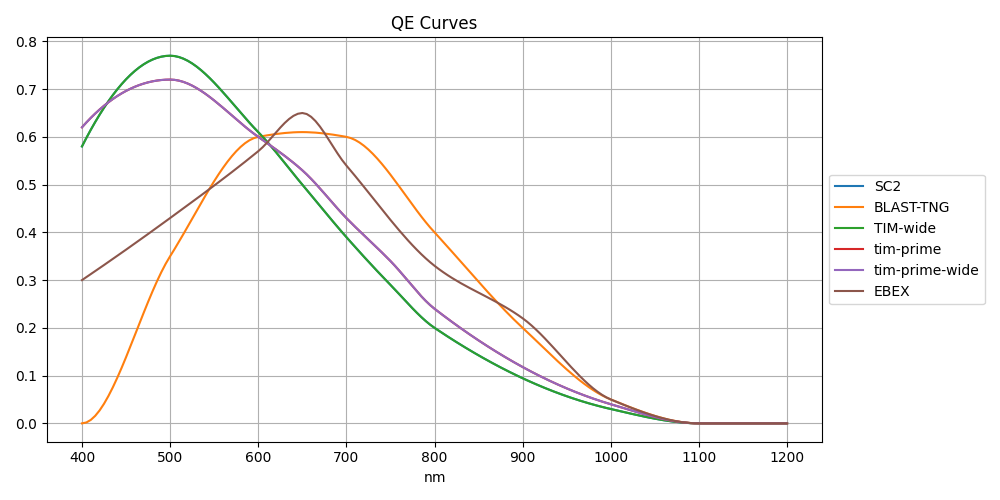

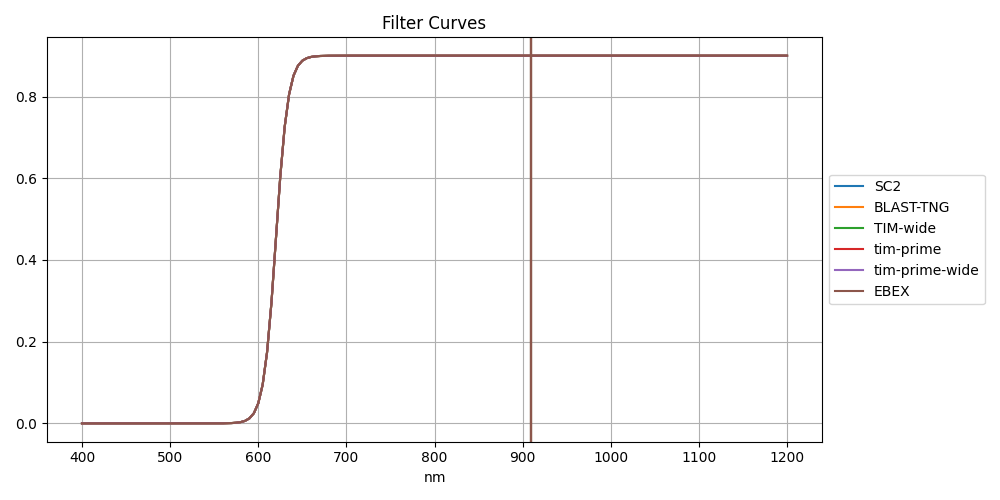

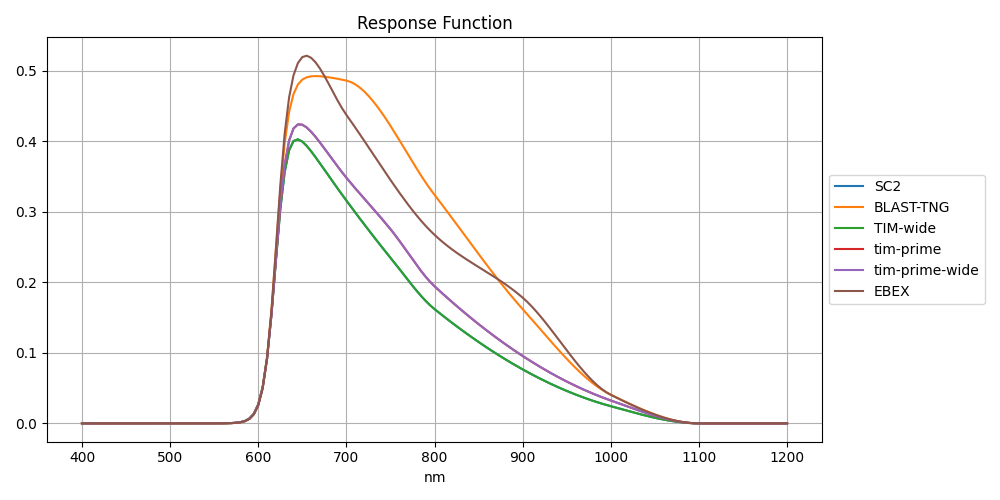

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(lambd, cam.sensor.qe(lambd), color=color, label=cam.name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('QE Curves')
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(lambd, cam.filter.tau(lambd), color=color, label=cam.name)
    ax.axvline(cam.get_mean_lambd(lambd), color=color)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('Filter Curves')
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
for cam in cams:
    ax.plot(lambd, cam.get_response(lambd), label=cam.name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid()
ax.set_title('Response Function')
fig.tight_layout()

### Sensor Size

SC2: [3.24922057 2.04116396] deg -> 6.632191936197747 deg2, plate scale: [6.04193907 6.04291963] arcsec / pix
BLAST-TNG: [2.64888494 1.98681852] deg -> 5.2628536538106285 deg2, plate scale: [7.01175425 7.01230066] arcsec / pix
TIM-wide: [7.63595212 4.80043666] deg -> 36.655904471411944 deg2, plate scale: [14.19908452 14.21181905] arcsec / pix
tim-prime: [4.18036976 2.38590979] deg -> 9.97398514624117 deg2, plate scale: [2.82457416 2.82541949] arcsec / pix
tim-prime-wide: [9.81644677 5.61023001] deg -> 55.07252426580622 deg2, plate scale: [6.6327343  6.64369344] arcsec / pix
EBEX: [3.9587087  2.63972249] deg -> 10.449892394713572 deg2, plate scale: [9.27822351 9.28027439] arcsec / pix


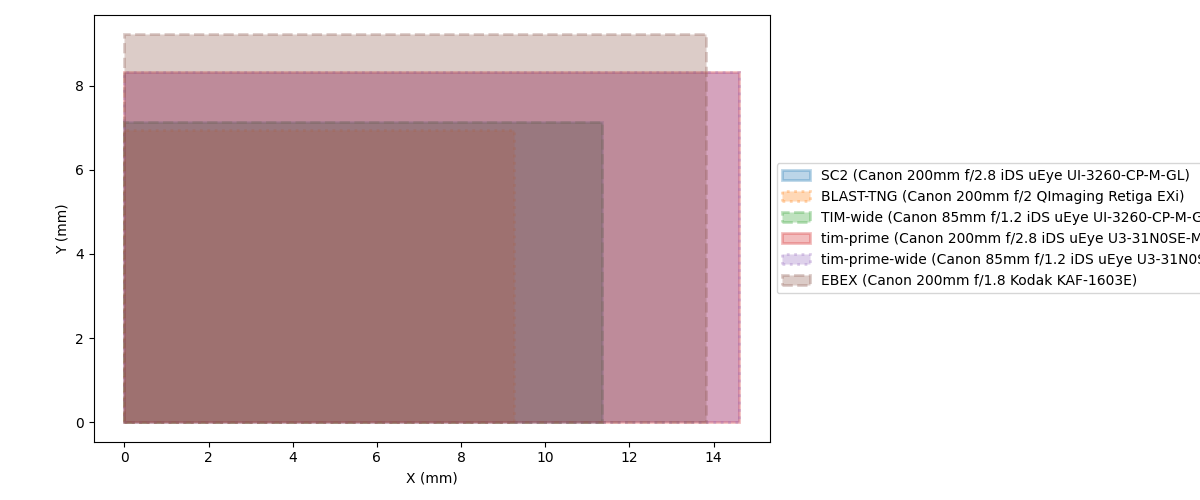

In [68]:
linestyles = ['-', ':', '--']
fig, ax = plt.subplots(figsize=(12,5))
for i, cam in enumerate(cams):
    ax.add_artist(
        Rectangle(
            (0, 0),
            cam.sensor.sensor_size[0].value,
            cam.sensor.sensor_size[1].value,
            color=f'C{i}',
            linestyle=linestyles[i % len(linestyles)],
            linewidth=2,
            label=f'{cam.name} ({cam.lens.name} {cam.sensor.name})',
            alpha=0.3
        ),
    )
    print(f'{cam.name}: {cam.fov} -> {cam.fov[0] * cam.fov[1]}, plate scale: {cam.plate_scale}')
ax.relim()
ax.autoscale_view()
ax.set_aspect('equal')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
fig.tight_layout()

### FoV and Plate Solving Performance

Rough initial estimates can be had using averages of star catalog abundances.

SC2: [3.24922057 2.04116396] deg -> 6.632191936197747 deg2 -> 3.3160959680988733 stars
BLAST-TNG: [2.64888494 1.98681852] deg -> 5.2628536538106285 deg2 -> 2.6314268269053143 stars
TIM-wide: [7.63595212 4.80043666] deg -> 36.655904471411944 deg2 -> 18.327952235705972 stars
tim-prime: [4.18036976 2.38590979] deg -> 9.97398514624117 deg2 -> 4.986992573120585 stars
tim-prime-wide: [9.81644677 5.61023001] deg -> 55.07252426580622 deg2 -> 27.53626213290311 stars
EBEX: [3.9587087  2.63972249] deg -> 10.449892394713572 deg2 -> 5.224946197356786 stars


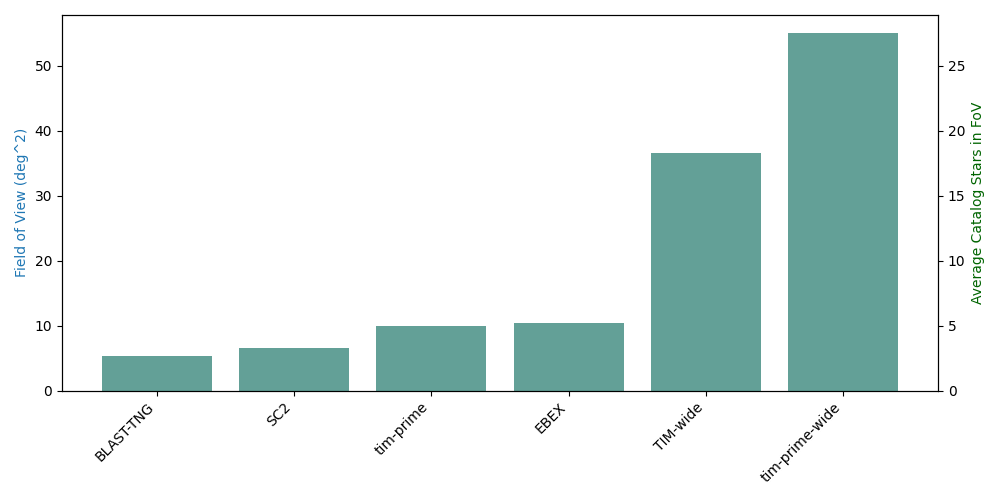

In [69]:
I_band_stars_per_deg2 = 0.5 / u.deg**2 # Alexander+ 1999, I-band estimate

fov_sort = np.argsort([(cam.fov[0] * cam.fov[1]).value for cam in cams])
fig, fov_area_ax = plt.subplots(figsize=(10,5))
fov_area_ax.bar(
    [cams[i].name for i in fov_sort],
    [cams[i].fov[0] * cams[i].fov[1] for i in fov_sort],
    color='C0',
    alpha=0.5
)
fov_area_ax.set_ylabel('Field of View (deg^2)')
fov_area_ax.yaxis.label.set_color('C0')
plt.xticks(rotation=45, ha='right')
avg_stars_ax = fov_area_ax.twinx()
avg_stars_ax.bar(
    [cams[i].name for i in fov_sort],
    [((cams[i].fov[0] * cams[i].fov[1]) * I_band_stars_per_deg2) for i in fov_sort],
    color='darkgreen',
    alpha=0.3
)
avg_stars_ax.set_ylabel('Average Catalog Stars in FoV')
avg_stars_ax.yaxis.label.set_color('darkgreen')
fig.tight_layout()

for cam in cams:
    print(f'{cam.name}: {cam.fov} -> {cam.fov[0] * cam.fov[1]} -> {(cam.fov[0] * cam.fov[1]) * I_band_stars_per_deg2} stars')

In [70]:
for cam in cams:
    print(f'{cam.name}, {cam.plate_scale}, {cam.lens.airy_diam(lambd).mean()}, {cam.lens.fwhm(lambd).mean()}')

SC2, [6.04193907 6.04291963] arcsec / pix, 5.636804625120648 arcsec, 2.3771606390365356 arcsec
BLAST-TNG, [7.01175425 7.01230066] arcsec / pix, 4.026289017943322 arcsec, 1.697971885026097 arcsec
TIM-wide, [14.19908452 14.21181905] arcsec / pix, 5.684172731214099 arcsec, 2.3971367788603724 arcsec
tim-prime, [2.82457416 2.82541949] arcsec / pix, 5.636804625120648 arcsec, 2.3771606390365356 arcsec
tim-prime-wide, [6.6327343  6.64369344] arcsec / pix, 5.684172731214099 arcsec, 2.3971367788603724 arcsec
EBEX, [9.27822351 9.28027439] arcsec / pix, 3.623660116148989 arcsec, 1.5281746965234875 arcsec


Assume an observation near TIM science field, out of galactic plane, near GOODS-S. What stars do we see?

In [71]:
region = coord.SkyCoord(ra='3:32:39.55', dec='-27d47m6.40s', unit=(u.deg, u.deg), frame='icrs') # GOODS-S
# region = coord.SkyCoord(ra='10h44m21.55s', dec='-59d53m25.0s', unit=(u.deg, u.deg), frame='icrs') # eta carinae
# region = coord.SkyCoord(ra='11h15m5.9s', dec='-61d16m10.7s', unit=(u.deg, u.deg), frame='icrs') # NGC 3603
# region = coord.SkyCoord(ra='11h05m33s', dec='-58d43m48s', unit=(u.deg, u.deg), frame='icrs') # NGC 3532, good initial target because open cluster
# region = coord.SkyCoord(ra='4:38:12.7', dec='21d39m05.2s', unit=(u.deg, u.deg), frame='icrs') # Zenith, Tucson, morning
# region = coord.SkyCoord(ra='06h50m26s', dec='+11d33m42s', unit=(u.deg, u.deg), frame='icrs') # Zenith, Tucson, evening, a real on-sky image solution from an 85mm f/1.2 run

max_area = np.max([(cam.fov[0] * cam.fov[1]).value for cam in cams])
fovs = np.arange(1, np.ceil(np.sqrt(max_area)) + 2.0, 0.5) * u.deg
xs = []
hitss = []
ecdfs = []
for fov in fovs: # TODO: query only the largest region and crop in after query for subregions
    table = get_tycho_stars(region, fov, fov, mag_limit=10, nlimit=1000)
    hits = table['VTmag']
    hitss.append(hits)
    # https://stackoverflow.com/a/75545886
    x, CDF_counts = np.unique(hits, return_counts = True)
    y = np.cumsum(CDF_counts)
    xs.append(x)
    ecdfs.append(y)
    print(fov)
    # Be nice to Vizier.
    time.sleep(.5)

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 1.0 degx1.0 deg


1.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 1.5 degx1.5 deg


1.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.0 degx2.0 deg


2.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.5 degx2.5 deg


2.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.0 degx3.0 deg


3.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.5 degx3.5 deg


3.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.0 degx4.0 deg


4.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.5 degx4.5 deg


4.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 5.0 degx5.0 deg


5.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 5.5 degx5.5 deg


5.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 6.0 degx6.0 deg


6.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 6.5 degx6.5 deg


6.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.0 degx7.0 deg


7.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.5 degx7.5 deg


7.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 8.0 degx8.0 deg


8.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 8.5 degx8.5 deg


8.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 9.0 degx9.0 deg


9.0 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 9.5 degx9.5 deg


9.5 deg


INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 9.816446765892575 degx5.610230012875608 deg


Max FoV: 9.816446765892575 deg x 5.610230012875608 deg


/home/evanmayer/.local/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


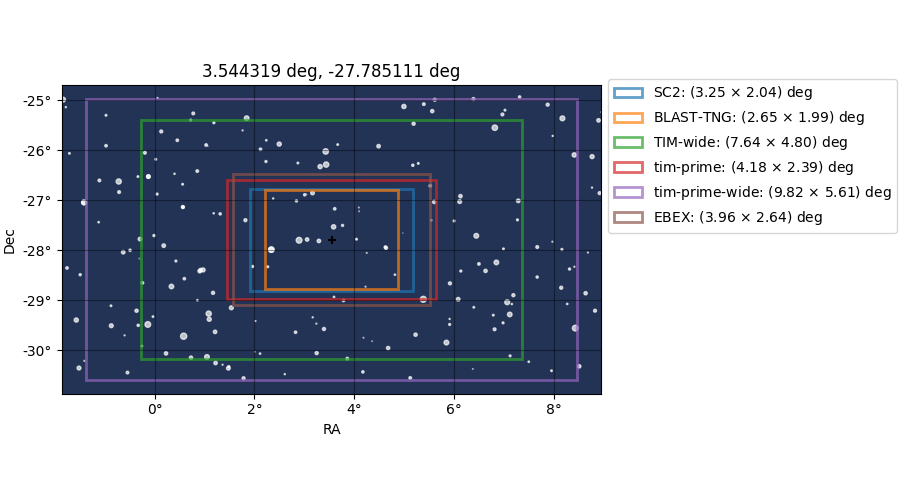

In [72]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_facecolor(darksky)

max_w = 0 * u.deg
max_h = 0 * u.deg
for cam in cams:
    if cam.fov[0] > max_w:
        max_w = cam.fov[0]
    if cam.fov[1] > max_h:
        max_h = cam.fov[1]
print(f'Max FoV: {max_w} x {max_h}')

table = get_tycho_stars(region, max_w, max_h, mag_limit=10, nlimit=1000)
ra_wrapped = ((table['RAmdeg'] + 180.) % 360.) - 180.
ax.scatter(
    ra_wrapped,
    table['DEmdeg'],
    s=20 - 20.9*(table['VTmag'] - table['VTmag'].min()) / (table['VTmag'].max() - table['VTmag'].min()),
    color='w',
    # c=table['VTmag'],
    # cmap='bone_r',
    alpha=0.7
)

for i, cam in enumerate(cams):
    rect = Rectangle(
        ((region.ra - cam.fov[0]/2).value, (region.dec-cam.fov[1]/2).value),
        cam.fov[0].value,
        cam.fov[1].value,
        facecolor='none',
        edgecolor=f'C{i}',
        linewidth=2,
        alpha=0.7,
        label=f'{cam.name}: ({cam.fov[0].to(u.deg).value:.2f} $\\times$ {cam.fov[1].to(u.deg).value:.2f}) deg'
    )
    ax.add_artist(rect)
ax.scatter(region.ra, region.dec, color='k', marker='+')

ax.set_title(f'{region.ra:.6f}, {region.dec:.6f}')
ax.relim()
ax.autoscale_view()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.grid(alpha=0.4, color='k')
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1, 0.5))
fig.tight_layout()

In [73]:
# Update the zero-point fluxes based on the filter in use:
for cam in cams:
    F0_new = get_zero_point_flux(lambd, cam.filter)
    print(F0_new)
    cam.filter.zero_point_flux = F0_new
    time.sleep(0.25)

1.2323235152474798e-12 W / (um cm2)
1.2323235152474798e-12 W / (um cm2)
1.2323235152474798e-12 W / (um cm2)
1.2323235152474798e-12 W / (um cm2)
1.2323235152474798e-12 W / (um cm2)
1.2323235152474798e-12 W / (um cm2)


In [74]:
# check: the zero-point flux of the Tycho V filter should agree with SVO's number: 3.99504e-9 (erg/cm2/s/A)
res0 = get_zero_point_flux(lambd, tycho_v).to(u.erg / u.s / u.cm**2 / u.Angstrom)

# and it should NOT depend on limits of integration
lambd_tmp = np.arange(200, 2505, 5) * u.nm
res1 = get_zero_point_flux(lambd_tmp, tycho_v).to(u.erg / u.s / u.cm**2 / u.Angstrom)

lambd_tmp = np.arange(300, 2305, 5) * u.nm
res2 = get_zero_point_flux(lambd_tmp, tycho_v).to(u.erg / u.s / u.cm**2 / u.Angstrom)

res0, res1, res2

(<Quantity 3.99504e-09 erg / (Angstrom s cm2)>,
 <Quantity 3.99504e-09 erg / (Angstrom s cm2)>,
 <Quantity 3.99504e-09 erg / (Angstrom s cm2)>)

### Signal-to-noise ratio

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.6488849385685946 degx1.9868185201938486 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.6488849385685946 degx1.9868185201938486 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'parti

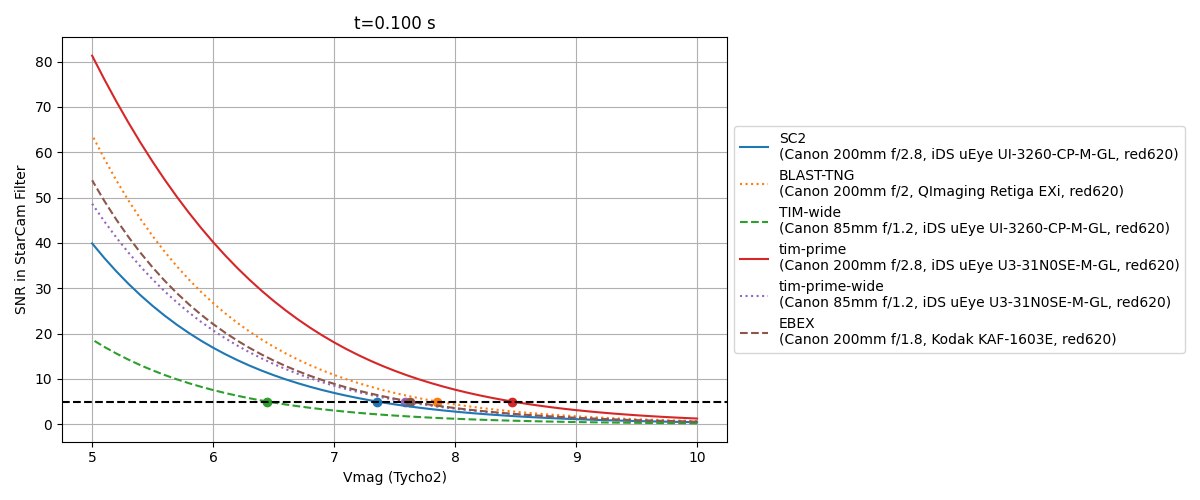

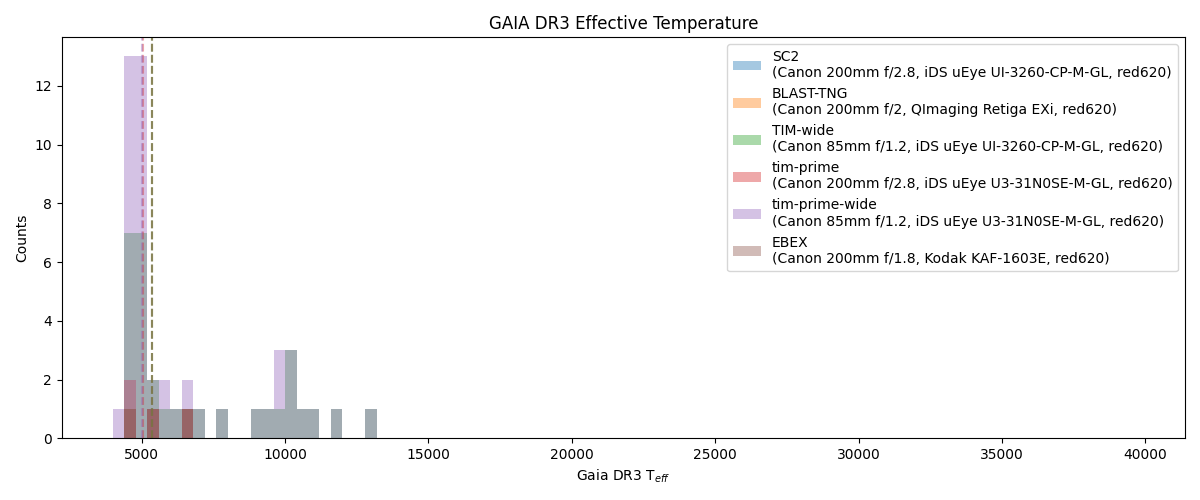

In [75]:
fig, ax = plt.subplots(figsize=(12,5))
linestyles = ['-', ':', '--']

fig_teff, ax_teff = plt.subplots(figsize=(12,5))
t_exp = 0.1 * u.s
mags_Vtyc = np.arange(10., 4.9, -0.1)
snr_limit = 5
limiting_mags = {}
for i, cam in enumerate(cams):
    # figg, axx = plt.subplots()
    # ts = np.arange(3000, 10000, 500) * u.K
    # for t in ts:
    #     model_curve = get_model_flux_density(t)
    #     mags = get_equivalent_mag(lambd, mags_Vtyc, tycho_v, cam.filter, model_curve)
    #     axx.plot(mags_Vtyc, mags / mags_Vtyc)
    # axx.plot(lambd, model_curve(lambd))
    # print(Teff, model_curve(lambd), Teffs, mags)

    # convert tycho mags into our filter system mags for SNR calc in our filters
    Teff, Teffs = get_median_Teff(region, cam.fov[0], cam.fov[1], return_array=True)
    model_curve = get_model_flux_density(Teff)

    # converting magnitudes requires an instrument with each filter installed.
    tyc_cam = copy.copy(cam)
    tyc_cam.filter = tycho_v
    mags = get_equivalent_mag(lambd, mags_Vtyc, tyc_cam.get_response, cam.get_response, model_curve)

    snrs = []
    for mag in mags:
        snr = simple_snr_spectral(t_exp, lambd, mag, cam)
        snrs.append(snr)
    l, = ax.plot(mags_Vtyc, snrs, label=f'{cam.name}\n({cam.lens.name}, {cam.sensor.name}, {cam.filter.name})', linestyle=linestyles[i%len(linestyles)])

    _, _, bars = ax_teff.hist(Teffs, bins=np.arange(4000, 40000, 400), label=f'{cam.name}\n({cam.lens.name}, {cam.sensor.name}, {cam.filter.name})', alpha=0.4)
    ax_teff.axvline(Teff, linestyle='--', color=bars[0].get_facecolor())

    limiting_mag = calc_limiting_mag(snr_limit, mags_Vtyc, np.array(snrs))
    ax.scatter(limiting_mag, snr_limit, color=l.get_color())
    limiting_mags[cam] = limiting_mag

ax.axhline(snr_limit, linestyle='--', color='k')
# ax.axhline(5, linestyle=':', color='k')
ax.set_xlabel('Vmag (Tycho2)')
ax.set_ylabel('SNR in StarCam Filter')
ax.set_title(f't={t_exp:0.3f}')
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

ax_teff.set_xlabel('Gaia DR3 T$_{eff}$')
ax_teff.set_ylabel('Counts')
ax_teff.set_title('GAIA DR3 Effective Temperature')
ax_teff.legend()
fig_teff.tight_layout()

Compare star distributions with SNR cut

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.6488849385685946 degx1.9868185201938486 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.180369763262014 degx2.38590979053927 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 9.816446765892575 degx5.610230012875608 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.9587086961778013 degx2.6397224945606923 deg


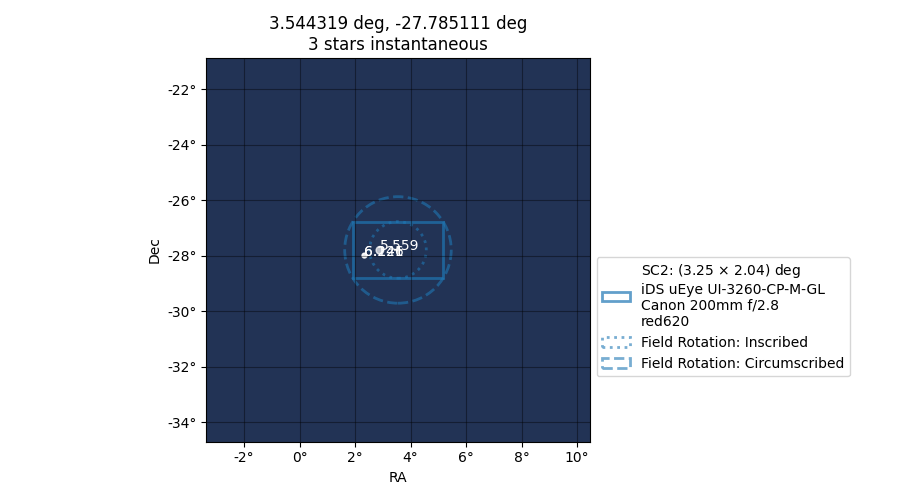

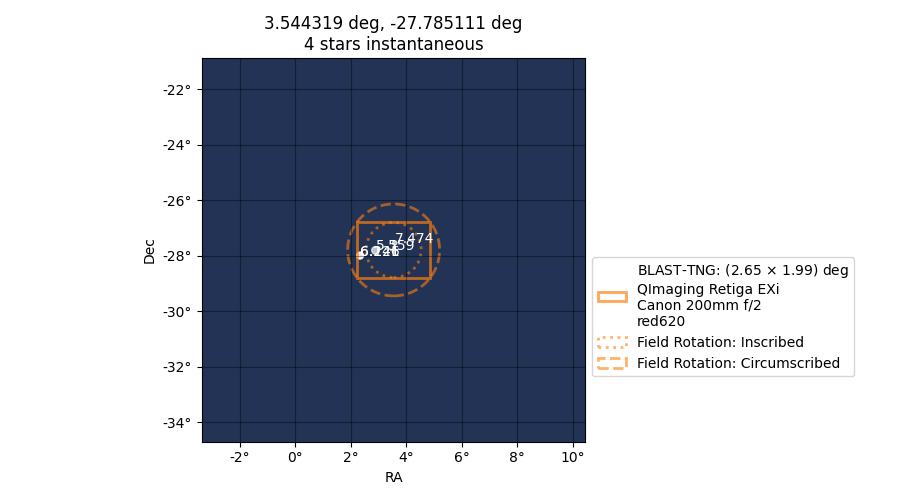

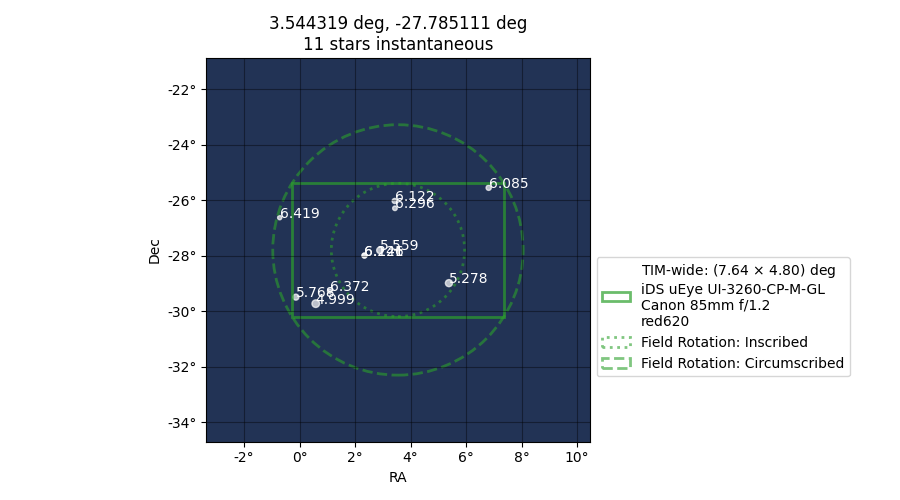

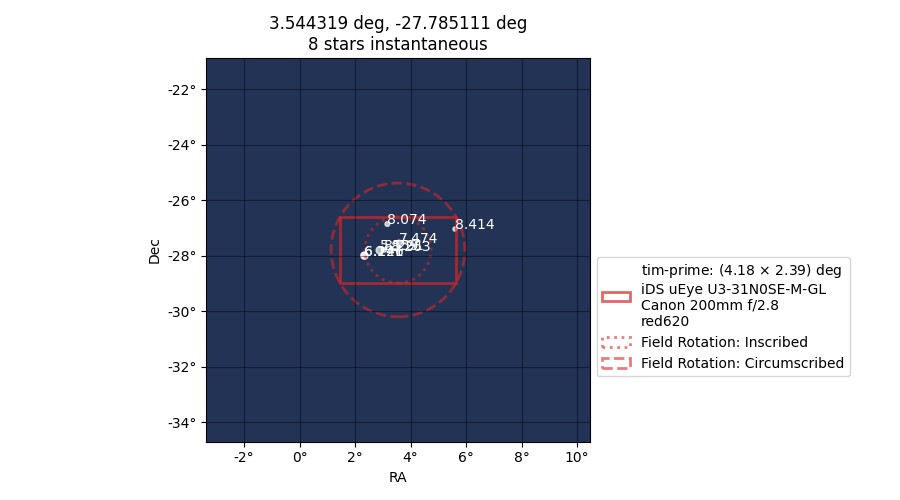

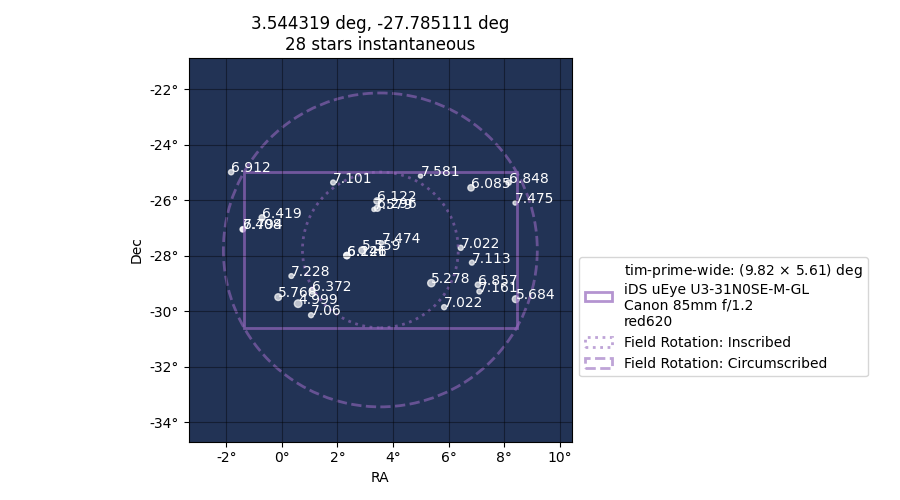

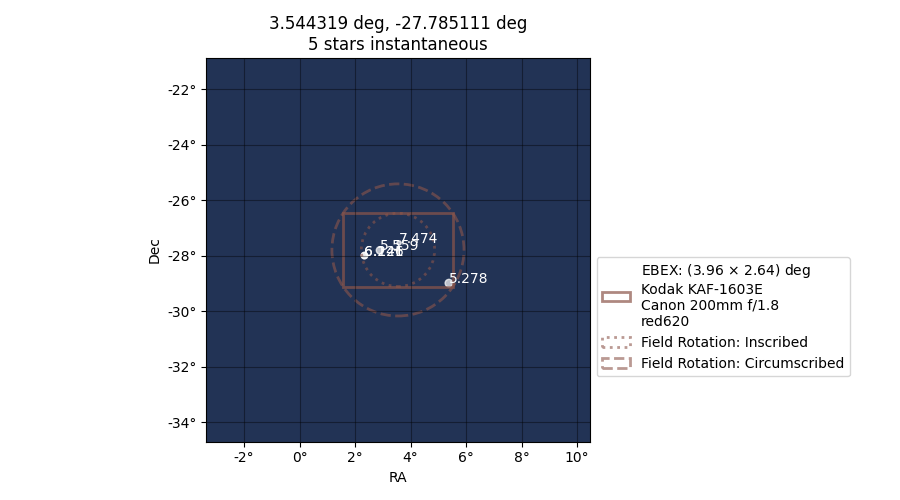

In [76]:
region = coord.SkyCoord(ra='3:32:39.55', dec='-27d47m6.40s', unit=(u.deg, u.deg), frame='icrs') # GOODS-S
# region = coord.SkyCoord(ra='10h44m21.55s', dec='-59d53m25.0s', unit=(u.deg, u.deg), frame='icrs') # eta carinae
# region = coord.SkyCoord(ra='11h15m5.9s', dec='-61d16m10.7s', unit=(u.deg, u.deg), frame='icrs') # NGC 3603
# region = coord.SkyCoord(ra='11h05m33s', dec='-58d43m48s', unit=(u.deg, u.deg), frame='icrs') # NGC 3532, good initial target because open cluster
# region = coord.SkyCoord(ra='4:38:12.7', dec='21d39m05.2s', unit=(u.deg, u.deg), frame='icrs') # Zenith, Tucson, morning
# region = coord.SkyCoord(ra='06h50m26s', dec='+11d33m42s', unit=(u.deg, u.deg), frame='icrs') # Zenith, Tucson, evening, a real on-sky image solution from an 85mm f/1.2 run
# region = coord.SkyCoord(ra='0', dec='+50d00m00s', unit=(u.deg, u.deg), frame='icrs')


# TODO: FIXME: astroquery returns stars that seem to be slightly outside the FoV according to the plotted rects. why?
# seems to be dec-dependent, worse at higher decs, so the solution would seem to be more accurate sky region plotting via
# TODO: create a WCS and use WCSAxes for better region plotting

for i, cam in enumerate(cams):
    fig, ax = plt.subplots(figsize=(9,5))
    ax.set_facecolor(darksky)

    table = get_tycho_stars(region, cam.fov[0], cam.fov[1], mag_limit=limiting_mags[cam], nlimit=1000)

    ra_wrapped = ((table['RAmdeg'] + 180.) % 360.) - 180.
    ax.scatter(
        ra_wrapped,
        table['DEmdeg'],
        s=20 - 20.9*(table['VTmag'] - table['VTmag'].min()) / (table['VTmag'].max() - table['VTmag'].min()) + 10,
        color='w',
        # c=table['VTmag'],
        # cmap='bone_r',
        alpha=0.7
    )
    for j, txt in enumerate(table['VTmag']):
        ax.annotate(txt, (ra_wrapped[j], table['DEmdeg'][j]), color='w')

    rect = Rectangle(
        ((region.ra - cam.fov[0]/2).value, (region.dec-cam.fov[1]/2).value),
        cam.fov[0].value,
        cam.fov[1].value,
        facecolor='none',
        edgecolor=f'C{i}',
        linewidth=2,
        alpha=0.7,
        label=(
            f'{cam.name}: ({cam.fov[0].to(u.deg).value:.2f} $\\times$ {cam.fov[1].to(u.deg).value:.2f}) deg\n' +
            f'{cam.sensor.name}\n{cam.lens.name}\n{cam.filter.name}'
        )
    )
    ax.add_artist(rect)
    # add circles to visualize field rotation
    circ = Circle(
        ((region.ra).value, (region.dec).value),
        np.min(cam.fov).value / 2.,
        facecolor='none',
        edgecolor=f'C{i}',
        linewidth=2,
        linestyle=':',
        alpha=0.6,
        label='Field Rotation: Inscribed'
    )
    ax.add_artist(circ)
    circ = Circle(
        ((region.ra).value, (region.dec).value),
        np.sqrt((cam.fov[0]/2.)**2 + (cam.fov[1]/2.)**2).value,
        facecolor='none',
        edgecolor=f'C{i}',
        linewidth=2,
        linestyle='--',
        alpha=0.6,
        label='Field Rotation: Circumscribed'
    )
    ax.add_artist(circ)

    ax.scatter(region.ra, region.dec, color='silver', marker='+')

    ax.set_title(f'{region.ra:.6f}, {region.dec:.6f}\n{len(table)} stars instantaneous')
    ax.autoscale_view()
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.grid(alpha=0.4, color='k')
    border = 2 * u.deg
    ax.set_xlim(region.ra - max_w/2 - border, region.ra + max_w/2 + border)
    ax.set_ylim(region.dec - max_w/2 - border, region.dec + max_w/2 + border)
    ax.relim()
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

Compare two systems as a function of sky brightness

In [77]:
# fig, ax = plt.subplots(figsize=(12,5))

# comp_cams = [SC2, tim_prime]
# brightness_factors = np.arange(0.25, 1.75, 0.25)
# cmax = 0.9
# cmin = 0.1
# cscale = (((brightness_factors - brightness_factors.min()) * (cmax - cmin)) / (brightness_factors.max() - brightness_factors.min())) + cmin
# cmaps = [
#     plt.cm.viridis(cscale),
#     plt.cm.inferno(cscale),
# ]
# t_exp = 0.1 * u.s
# snr_limit = 5
# for j, factor in enumerate(brightness_factors):
#     for i, cam in enumerate(comp_cams):
#         # convert tycho mags into our filter system mags for SNR calc in our filters
#         Teff = get_median_Teff(region, cam.fov[0], cam.fov[1])
#         model_curve = get_model_flux_density(Teff)
#         # converting magnitudes requires an instrument with each filter installed.
#         tyc_cam = copy.copy(cam)
#         tyc_cam.filter = tycho_v
#         mags = get_equivalent_mag(lambd, mags_Vtyc, tyc_cam.get_response, cam.get_response, model_curve)
#         snrs = []
#         for mag in mags:
#             snr = simple_snr_spectral(t_exp, lambd, mag, cam, sky_brightness_factor=factor)
#             snrs.append(snr)
#         l, = ax.plot(
#             mags_Vtyc,
#             snrs,
#             color=cmaps[i][j],
#             linestyle=linestyles[i%len(linestyles)],
#             label=f'{cam.name}, brightness_factor={factor:.2f}'
#         )

#         limiting_mag = calc_limiting_mag(snr_limit, mags_Vtyc, np.array(snrs))
#         ax.scatter(limiting_mag, snr_limit, color=l.get_color())

# ax.axhline(snr_limit, linestyle='--', color='k')
# ax.set_xlabel('Vmag (Tycho2)')
# ax.set_ylabel('SNR in StarCam Filter')
# ax.set_title(f't={t_exp:0.3f}')
# ax.grid()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# fig.tight_layout()

### Saturation

Typically, full well "currents" are in units of electrons, and are specified (to make the sensors look good) at base gain. This may not be where you'd like to operate, however; depending on the size of the signal above the noise and the bit depth of the image, you may want to use additional gain to raise the difference between star counts and background counts above a single ADU - this quantization limitation is especially bad for low bit depth cameras with high background noise.

Having additional full well capacity allows one to raise the gain, consuming dynamic range to counter the bit depth problem.

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.6488849385685946 degx1.9868185201938486 deg
INFO:root:Querying xMatch service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.6488849385685946 degx1.9868185201938486 deg, r=1.0 arcsec, vizier:I/355/paramp
/home/evanmayer/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'parti

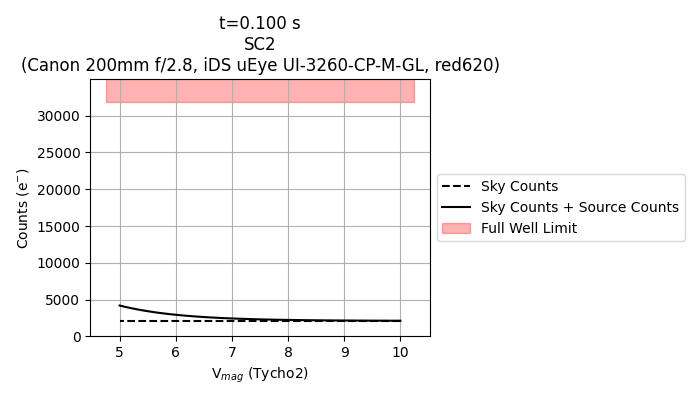

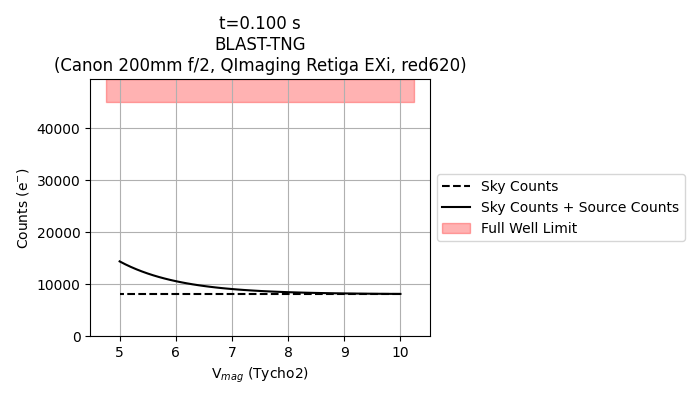

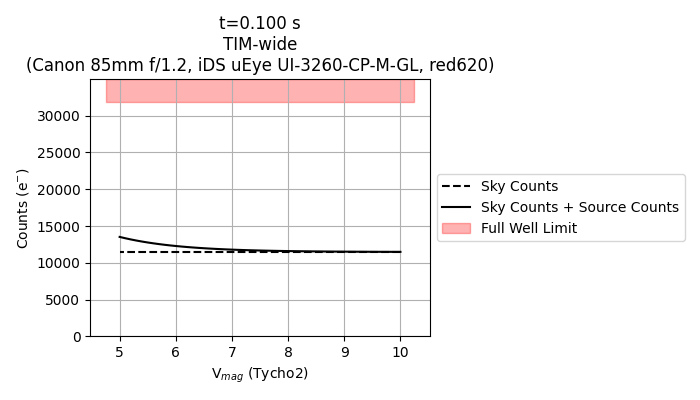

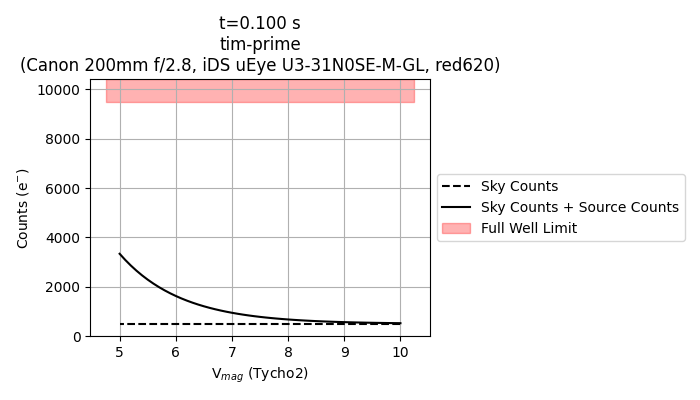

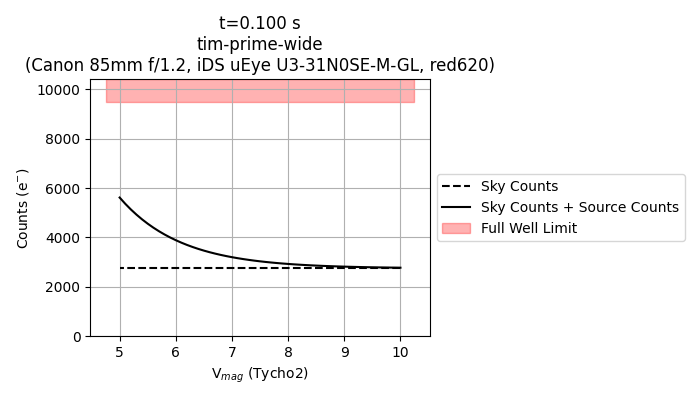

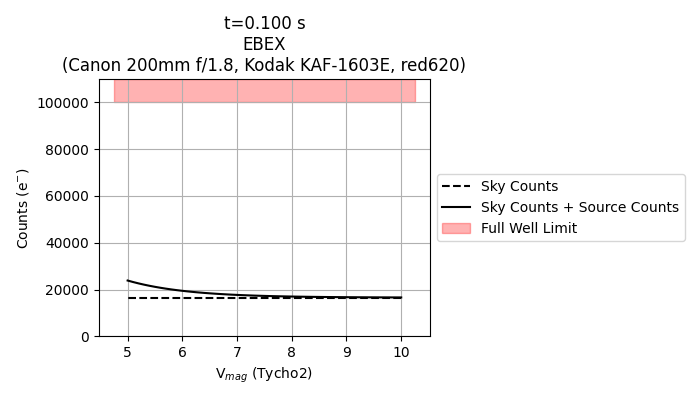

In [78]:
for i, cam in enumerate(cams):
    fig, ax = plt.subplots(figsize=(7,4))
    Teff = get_median_Teff(region, cam.fov[0], cam.fov[1])
    model_curve = get_model_flux_density(Teff)
    # converting magnitudes requires an instrument with each filter installed.
    tyc_cam = copy.copy(cam)
    tyc_cam.filter = tycho_v
    mags = get_equivalent_mag(lambd, mags_Vtyc, cam_tyc.get_response, cam.get_response, model_curve)
    src = []
    sky = []
    summed = []
    for mag in mags:
        _, (source_electrons_per_sec, sky_electrons_per_sec, aperture_area_px) = simple_snr_spectral(t_exp, lambd, mag, cam, return_components=True)
        e_per_px_source = (t_exp / aperture_area_px) * source_electrons_per_sec
        e_per_px_sky = (t_exp / aperture_area_px) * sky_electrons_per_sec
        e_per_px = e_per_px_source + e_per_px_sky
        src.append(e_per_px_source.value)
        sky.append(e_per_px_sky.value)
        summed.append(e_per_px.value)

    ax.plot(mags_Vtyc, sky, color='k', linestyle='--', label='Sky Counts')
    ax.plot(mags_Vtyc, summed, color='k', label='Sky Counts + Source Counts')

    ax.set_ylim(0, 1.1 * max([cam.sensor.full_well.value, np.max(summed)]))
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.fill_between([xmin, xmax], cam.sensor.full_well.value, y2=ymax, color='r', alpha=0.3, label='Full Well Limit')
    ax.set_xlabel('V$_{mag}$ (Tycho2)')
    ax.set_ylabel('Counts (e$^{-}$)')
    ax.set_title(f't={t_exp:0.3f}\n{cam.name}\n({cam.lens.name}, {cam.sensor.name}, {cam.filter.name})')
    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

### Plate Solving Potential

The best star camera will have a good combination of SNR (greatest magnitude depth) and field of view, in order to see multiple stars bright enough to perform a lost-in-space plate solve.

INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.2492205683270936 degx2.0411639643203485 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 2.6488849385685946 degx1.9868185201938486 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 7.635952119314747 degx4.800436657884839 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 4.180369763262014 degx2.38590979053927 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 9.816446765892575 degx5.610230012875608 deg
INFO:root:Querying Vizier service... <SkyCoord (ICRS): (ra, dec) in deg
    (3.54431944, -27.78511111)>, 3.9587086961778013 degx2.6397224945606923 deg


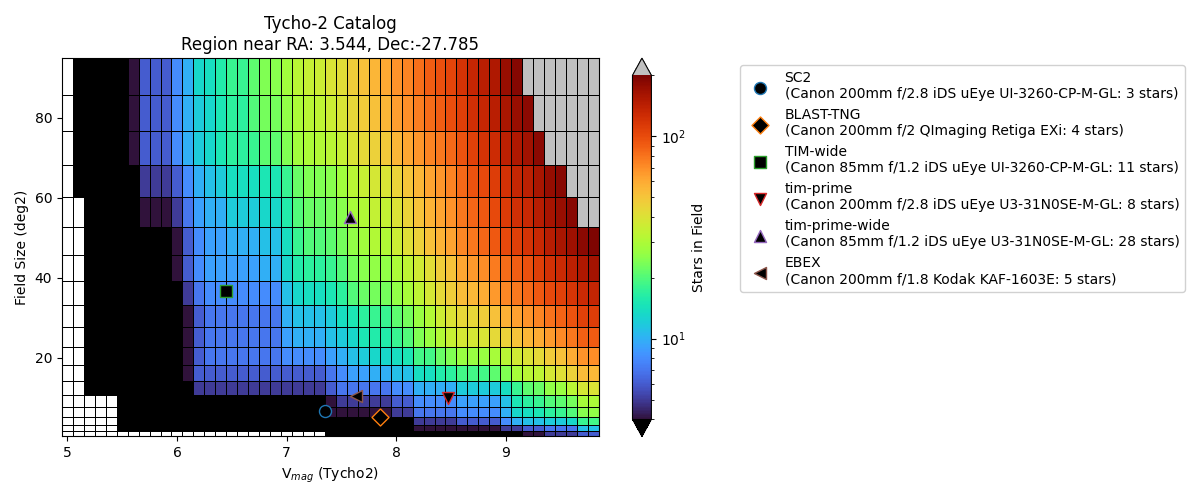

In [79]:
# Create a CDF heatmap in mag/fov-space for the number of stars in the catalog
magbins = np.arange(mags_Vtyc.min(), mags_Vtyc.max(), 0.1)
countss = []
for i, fov in enumerate(fovs):
    h, b = np.histogram(hitss[i], bins=magbins)
    countss.append(np.cumsum(h))
X, Y = np.meshgrid(b[:-1], fovs**2)
Z = np.stack(countss)

fig, ax = plt.subplots(figsize=(12,5))
cmap = plt.get_cmap('turbo').copy()
cmap.set_extremes(under='k', over='silver')
im = ax.pcolormesh(X, Y, Z, edgecolors='k', linewidth=0.5, cmap=cmap, norm=LogNorm(vmin=4, vmax=200))
fig.colorbar(im, ax=ax, label='Stars in Field', extend='both')

# identify cameras in mag/FoV parameter space
marker_styles = ['o', 'D', 's', 'v', '^', '<', '>', '*', 'p', 'd', 'P', 'X']
for i, cam in enumerate(cams):
    limiting_mag = limiting_mags[cam]

    table = get_tycho_stars(region, cam.fov[0], cam.fov[1], mag_limit=limiting_mag, nlimit=1000)
    est_stars = len(table)

    ax.scatter(
        limiting_mag,
        (cam.fov[0] * cam.fov[1]),
        s=75,
        marker=marker_styles[i % len(marker_styles)],
        color='k',
        edgecolor=f'C{i}',
        label=f'{cam.name}\n({cam.lens.name} {cam.sensor.name}: {est_stars} stars)'
    )
ax.legend(loc='upper left', facecolor='w', fontsize=10, framealpha=0.9, bbox_to_anchor=(1.25, 1.))
ax.set_title(f'Tycho-2 Catalog\nRegion near RA: {region.ra.deg:.3f}, Dec:{region.dec.deg:.3f}')
ax.set_xlabel('V$_{mag}$ (Tycho2)')
ax.set_ylabel('Field Size (deg2)')
ax.relim()
ax.autoscale_view()
fig.tight_layout()
plt.show()

### Filter Optimization

84060 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: 400.0
86788 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: 400.0
74411 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: 425.0
77036 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: 425.0
62686 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: 450.0
65167 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: 450.0
51461 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: 475.0
53778 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: 475.0
41245 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-

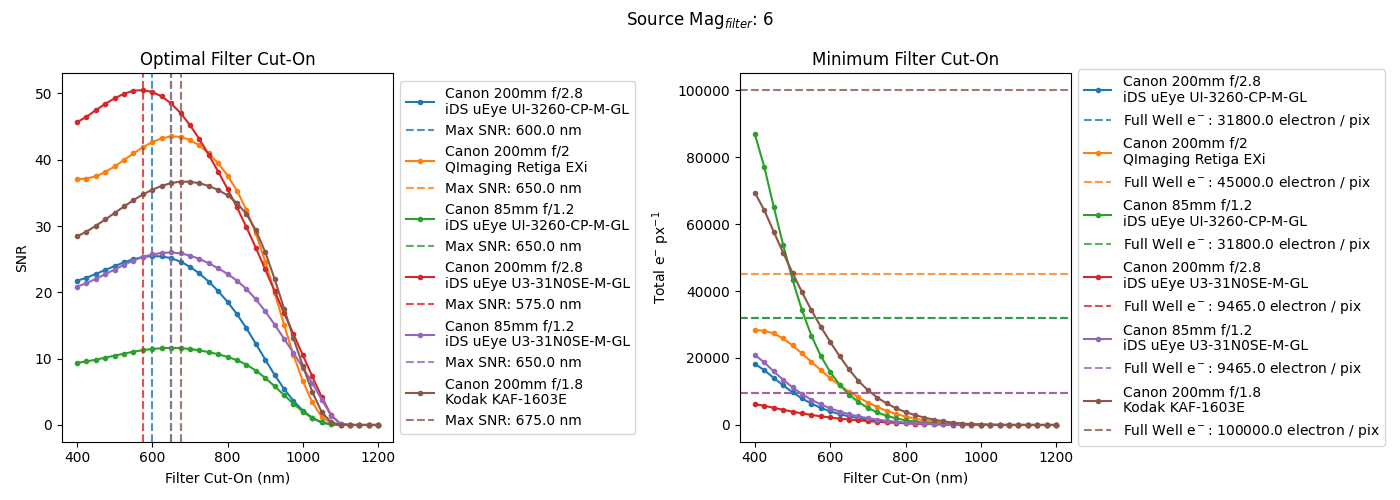

In [80]:
fig, (ax, ax1) = plt.subplots(figsize=(14,5), ncols=2, sharex=True)
mag = 6
fig.suptitle('Source Mag$_{filter}$: ' + f'{mag}')
for i, cam in enumerate(cams):
    snrs = []
    e_per_pxs = []
    for filt in filter_array:
        cam = StarCamera(cam.sensor, cam.lens, filt, name=f'{cam.sensor.name}-{filt.name}')
        snr, (source_electrons_per_sec, sky_electrons_per_sec, aperture_area_px) = simple_snr_spectral(t_exp, lambd, mag, cam, return_components=True)
        e_per_px_source = (t_exp / aperture_area_px) * source_electrons_per_sec
        e_per_px_sky = (t_exp / aperture_area_px) * sky_electrons_per_sec
        e_per_px = e_per_px_source + e_per_px_sky
        e_per_pxs.append(e_per_px.value)
        snrs.append(snr)
    ax.plot(
        [float(filter_array[i].name) for i in range(len(filter_array))],
        snrs,
        marker='.',
        label=f'{cam.lens.name}\n{cam.sensor.name}'
    )
    max_i = np.argmax(snrs)
    ax.axvline(
        float(filter_array[max_i].name),
        linestyle='--',
        color=f'C{i}',
        alpha=0.8,
        label=f'Max SNR: {float(filter_array[max_i].name)} nm'
    )

    ax1.plot(
        [float(filter_array[i].name) for i in range(len(filter_array))],
        e_per_pxs,
        marker='.',
        label=f'{cam.lens.name}\n{cam.sensor.name}'
    )
    ax1.axhline(
        cam.sensor.full_well.value,
        linestyle='--',
        color=f'C{i}',
        alpha=0.8,
        label=f'Full Well e$^-$: {cam.sensor.full_well}'
    )

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
ax.set_xlabel('Filter Cut-On (nm)')
ax.set_ylabel('SNR')
ax.set_title('Optimal Filter Cut-On')

ax1.legend(loc='center left', bbox_to_anchor=(1., 0.5), fontsize=10)
ax1.set_xlabel('Filter Cut-On (nm)')
ax1.set_ylabel('Total e$^{-}$ px$^{-1}$')
ax1.set_title('Minimum Filter Cut-On')
fig.tight_layout()

### Pixel Values as a Function of Sky Brightness

In [81]:
tim_narrow.plate_scale, SC2.plate_scale

(<Quantity [4.02855916, 4.02884981] arcsec / pix>,
 <Quantity [6.04193907, 6.04291963] arcsec / pix>)

34876 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
34908 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
39235 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
39268 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
43594 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
43627 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
47954 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
47986 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620


[ 802.07113707 1604.14227415 2406.21341122 3208.28454829 4010.35568537
 4812.42682244 5614.49795951 6416.56909659 7218.64023366 8020.71137074
 8822.78250781] electron
[ 4359.44554551  8718.89109103 13078.33663654 17437.78218206
 21797.22772757 26156.67327309 30516.1188186  34875.56436412
 39235.00990963 43594.45545515 47953.90100066] electron
[ 377.15390243  754.30780486 1131.46170729 1508.61560971 1885.76951214
 2262.92341457 2640.077317   3017.23121943 3394.38512186 3771.53902428
 4148.69292671] electron


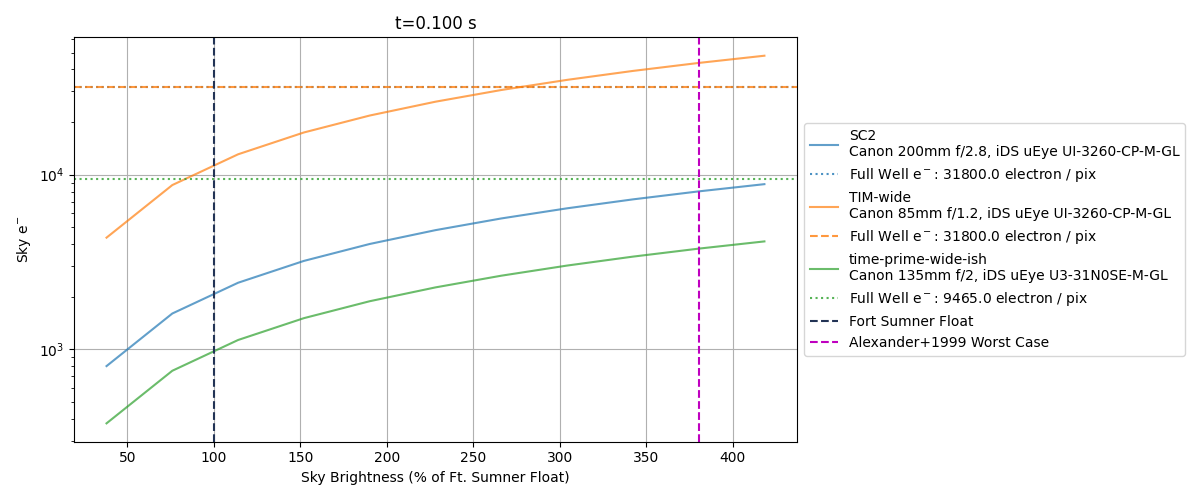

In [82]:
fig, ax = plt.subplots(figsize=(12,5))

linestyles = [':', '--']
cams_sky = [SC2, tim_wide, tim_prime_wide_ish]
brightness_factors = np.arange(0.1, 1.15, 0.1)
t_exp = 0.1 * u.s
for i, cam in enumerate(cams_sky):
    sky_electrons_list = []
    for factor in brightness_factors:
        _, (source_electrons_per_sec, sky_electrons_per_sec, aperture_area_px) = simple_snr_spectral(
            t_exp,
            lambd,
            10,
            cam,
            sky_brightness_factor=factor,
            return_components=True
        )
        sky_electrons_list.append(sky_electrons_per_sec / aperture_area_px * t_exp)
    sky_electrons_arr = np.array([item.value for item in sky_electrons_list]) * sky_electrons_list[0].unit * aperture_area_px.unit
    print(sky_electrons_arr)
    l, = ax.plot(
        brightness_factors * 100. / 0.263,
        sky_electrons_arr,
        alpha=0.7,
        label=f'{cam.name}\n{cam.lens.name}, {cam.sensor.name}'
    )
    ax.axhline(
        cam.sensor.full_well.value,
        linestyle=linestyles[i%len(linestyles)],
        color=f'C{i}',
        alpha=0.8,
        label=f'Full Well e$^-$: {cam.sensor.full_well}'
    )

ax.axvline(100, linestyle='--', color=darksky, label='Fort Sumner Float')
ax.axvline(100 / 0.263, linestyle='--', color='m', label='Alexander+1999 Worst Case')
ax.set_xlabel('Sky Brightness (% of Ft. Sumner Float)')
ax.set_ylabel('Sky e$^{-}$')
ax.set_title(f't={t_exp:0.3f}')
ax.set_yscale('log')
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

32696 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
32728 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
34876 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
34908 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
37055 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
37088 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
39235 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
39268 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-3260-CP-M-GL, lens: Canon 85mm f/1.2, filter: red620
41415 electron / pix > 31800 electron / pix
sensor: iDS uEye UI-

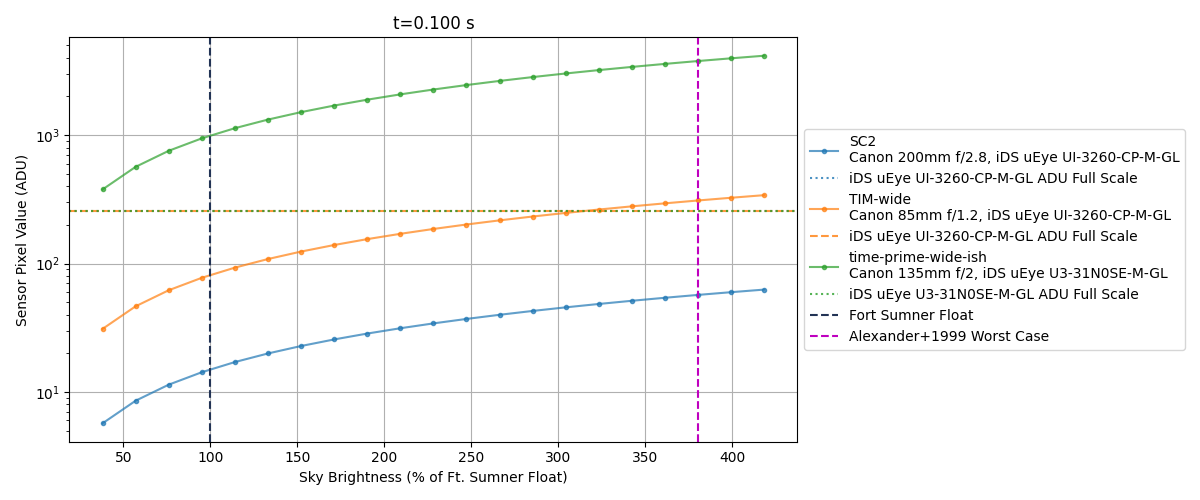

In [83]:
fig, ax = plt.subplots(figsize=(12,5))

linestyles = [':', '--']
brightness_factors = np.arange(0.1, 1.15, 0.05)
t_exp = 0.1 * u.s
for i, cam in enumerate(cams_sky):
    sky_electrons_per_sec_list = []
    for factor in brightness_factors:
        _, (source_electrons_per_sec, sky_electrons_per_sec, aperture_area_px) = simple_snr_spectral(
            t_exp,
            lambd,
            10,
            cam,
            sky_brightness_factor=factor,
            return_components=True
        )
        sky_electrons_per_sec_list.append(sky_electrons_per_sec / aperture_area_px * t_exp * cam.sensor.gain_adu_per_e)
    sky_electrons_per_sec_arr = np.array([item.value for item in sky_electrons_per_sec_list]) * sky_electrons_per_sec_list[0].unit * aperture_area_px.unit * cam.sensor.gain_adu_per_e.unit
    l, = ax.plot(
        brightness_factors * 100. / 0.263,
        sky_electrons_per_sec_arr,
        marker='.',
        alpha=0.7,
        label=f'{cam.name}\n{cam.lens.name}, {cam.sensor.name}'
    )
    ax.axhline(
        2 ** cams_sky[i].sensor.bits - 1,
        color=f'C{i}',
        linestyle=linestyles[i%len(linestyles)],
        alpha=0.8,
        label=f'{cams_sky[i].sensor.name} ADU Full Scale'
    )
ax.axvline(100, linestyle='--', color=darksky, label='Fort Sumner Float')
ax.axvline(100 / 0.263, linestyle='--', color='m', label='Alexander+1999 Worst Case')
ax.set_xlabel('Sky Brightness (% of Ft. Sumner Float)')
ax.set_ylabel('Sensor Pixel Value (ADU)')
ax.set_title(f't={t_exp:0.3f}')
ax.set_yscale('log')
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

### Storage Economy

For a total mission time of 512.0 h, @ cadence 3.0 s:
SC2: 2.4 MP, 2.35 MB per pic, 1446 GB total storage
BLAST-TNG: 1.4 MP, 2.08 MB per pic, 1278 GB total storage
TIM-wide: 2.4 MP, 2.35 MB per pic, 1446 GB total storage
tim-prime: 16.2 MP, 16.20 MB per pic, 9952 GB total storage
tim-prime-wide: 16.2 MP, 16.20 MB per pic, 9952 GB total storage
EBEX: 1.6 MP, 2.75 MB per pic, 1691 GB total storage


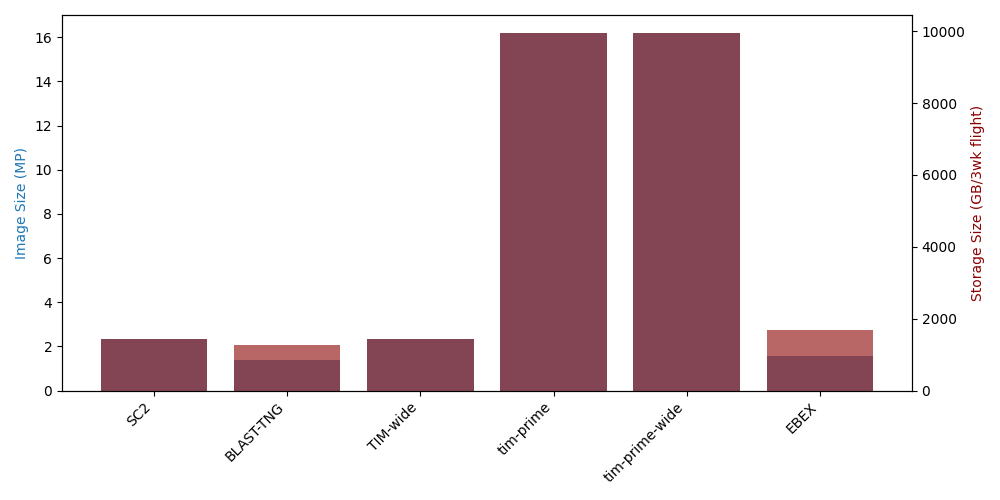

In [84]:
float_time = 8 * 3600 * u.s + (3 * 7 * 24 * 3600) * u.s
cadence = 3 * u.s
num_pics = float_time / cadence
print(f'For a total mission time of {float_time * (u.hr / (3600. * u.s))}, @ cadence {cadence}:')
for cam in cams:
    print(f'{cam.name}: {cam.sensor.megapixels:.1f} MP, {cam.sensor.frame_storage_size / 1e6 / 8:.2f} MB per pic, {num_pics * cam.sensor.frame_storage_size / 1e6 / 8 / 1000:.0f} GB total storage')

fig, megapix = plt.subplots(figsize=(10,5))
megapix.bar([cam.name for cam in cams], [cam.sensor.megapixels for cam in cams], color='C0', alpha=0.6)
megapix.set_ylabel('Image Size (MP)')
megapix.yaxis.label.set_color('C0')
plt.xticks(rotation=45, ha='right')
storage = megapix.twinx()
storage.bar([cam.name for cam in cams], [(num_pics * cam.sensor.frame_storage_size / 1e6 / 8 / 1000) for cam in cams], color='darkred', alpha=0.6)
storage.set_ylabel('Storage Size (GB/3wk flight)')
storage.yaxis.label.set_color('darkred')
fig.tight_layout()

### Cost Optimization

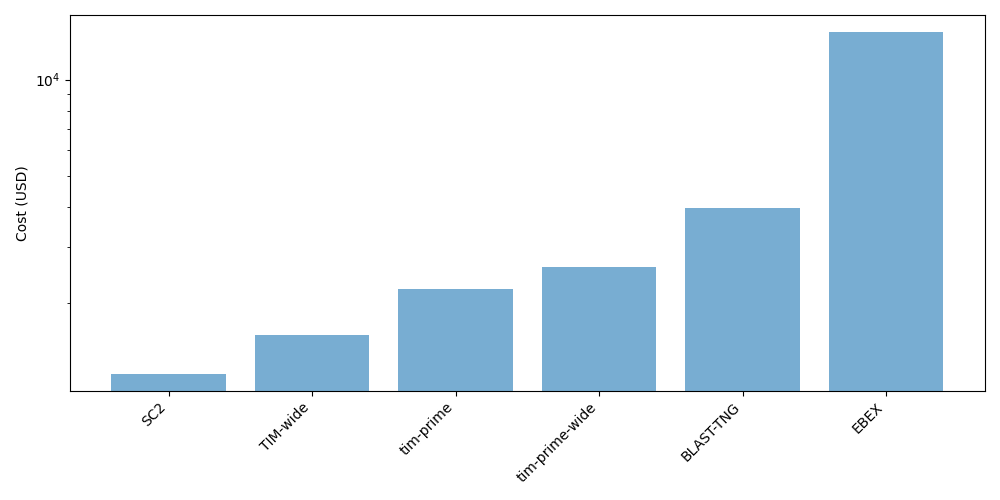

In [85]:
fig, cost = plt.subplots(figsize=(10,5))
cost_sort = np.argsort([cam.cost for cam in cams])
cost.bar([cams[i].name for i in cost_sort], [cams[i].cost for i in cost_sort], color='C0', alpha=0.6)
cost.set_ylabel('Cost (USD)')
cost.set_yscale('log')
plt.xticks(rotation=45, ha='right')
fig.tight_layout()

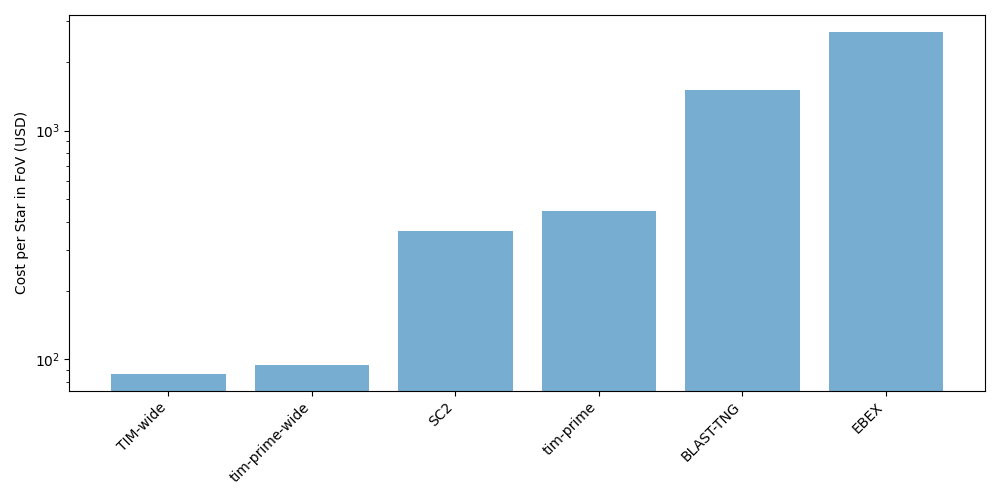

In [86]:
fig, cost = plt.subplots(figsize=(10,5))
cost_sort = np.argsort([cam.cost / ((cam.fov[0] * cam.fov[1]) * I_band_stars_per_deg2) for cam in cams])
cost.bar(
    [cams[i].name for i in cost_sort],
    [cams[i].cost / ((cams[i].fov[0] * cams[i].fov[1]) * I_band_stars_per_deg2) for i in cost_sort],
    color='C0',
    alpha=0.6
)
cost.set_ylabel('Cost per Star in FoV (USD)')
plt.xticks(rotation=45, ha='right')
cost.set_yscale('log')
fig.tight_layout()

## Recommendations

<font color='red'>TODO: revisit recommendations. New predictions suggest that wide FoV might win out due to catching more bright stars, even if poor pixel matching throws away SNR.</font>

### TIM Science Flight

<hr>

For TIM science flight, I recommend choosing the iDS uEye U3-31N0SE-M-GL. It should net ~5 stars on average over a 10deg^2 FoV at SNR > 2. It has the highest cost overall and highest cost per star, but shooting in 8bit allows us to avoid extensive rewriting of existing software and tamps down the data storage problem to a single ~12 TB drive in flight.

An additional ~40% SNR boost for any of these sensors could be gained by switching to an f/2 lens. We would have to buy secondhand lenses, and re-buy filters for the filter drawers on the f/2 lens; the front element is so large that filters are impractical and are instead installed at the rear.

I do not recommend further filtering into the IR than our existing Tiffen R29 (650 nm). Si-based sensors' QE limitations at ~1000 nm mean that further filtering decreases the total number of photons available from stars and begins eating into SNR, despite the reduction in background, which is flattening the further we push into SWIR. For similar reasons, narrowband interference filters like Halpha are not recommended.

### New Development

<hr>

If new development is pursued for risk reduction, I propose developing a "widefield" option: A Canon 200mm f/2.8 EF lens coupled via the same Birger focuser to a ZWO ASI294MM. Widefield star camera images have distinct advantages, if the PSF matching problem can be overcome - TIM's primary science field is not in the galactic plane, so we should expect fewer stars per image than average. We should try to maximize the number of candidate stars in a given image.

Advantages:
* Wide FoV: ~20.6deg^2, ~10.3 stars, drastically improving chances of successful plate solve
* Sufficient SNR~2 over wider field than TIM test flight due to smaller pixels and higher red QE
* Low data storage requirements
* Software rewrite an opportunity to use more ADC bits, diversify codebase to amortize risk
* Small cost per star in FoV

Risks:
1. SNR still low on 9th mag stars
2. Software rewrite for ZWO API
3. Software effort to adhere to existing flight software interfaces
4. Increased storage requirements

Risk Mitigations:
1. Double exposure time to 0.2s to increase SNR from 4.6 um pixel mismatch
2. Existing ZWO C/Python API examples, ECM has working Python tetra3 plate solver
3. --
4. Run widefield SC at lower cadence to reduce storage requirements

### SWIR

<hr>

I also explored a high-MP (~5 MP) SWIR camera, based on Sony's newest high resolution sensor model, IMX992. This sensor began appearing in COTS integrators' offerings in [Dec. 2024](https://www.framos.com/en/news/sonys-wide-spectrum-image-sensors-imx992-imx993). There is [evidence](https://www.qhyccd.com/scientific-camera-qhy990_qhy991_qhy992/) of daytime operation on stars. The sensor has extreme SWIR QE (>70% at 1000 nm), which supports much more aggressive filtering out past ~800 nm. Current InGaAs technology has low pixel density and somewhat high pixel size, making it difficult to sample the lens PSF. However, the additional background hit from failing to match pixel size to PSF is mitigated by increased SWIR sensitivity. This opens up a new regime for daytime star camera design - high SNR on wide fields:

* Extreme SNR on typical field sizes:
    * SNR = 11 on a 9th mag star
    * 3.7 x 3 deg FoV - ~6 stars
    * ~5.2 arcsec/px
* Balance of SNR and plate scale:
    * SNR = 11 on a 9th mag star
    * 5.9 x 4.8 deg FoV - ~14 stars
    * ~8.4 arcsec/px - lower astrometric precision
* Widen FoV until SNR is similar to Si-based sensors:
    * SNR = 4 on a 9th mag star
    * 10 x 8 deg FoV - ~41 stars
    * ~14.2 arcsec/px - lower astrometric precision

Each option is based on a Canon EF lens compatible with the current Birger focuser.

SWIR sensors require active cooling to control dark current, which adds complexity to the design - TIM would need additional strapping to offload heat from the sensor + TEC via the sensor package. Cost is also extremely high - ~$20,400 for a single sensor.

All options would have moderate storage requirements compared to the APS-C-sized, high-density sensors that would be required to get a similar SNR/FoV combination by exploiting small pixels. But if you're going to pony up >$20,000, you probably don't care about a few hundred bucks in hard drives...

Caveats:
* Stellar flux for SNR is based on magnitudes vs. I-band zero-point flux - essentially assumes constant flux density out into the SWIR, which cannot be true, and should be wrong (too high) by a factor of a few judging from a blackbody curve
    * Cousins R zero-point flux ~6x greater than J
    * I should at least look for zero-point fluxes in other filters that are better matched to the coverage of particular filter+QE combos
    * BB model as input, rather than filter zero-points and stellar magnitudes?
* Conventional photographic lenses may have poor transmission and poor correction/ultimate focus in SWIR - this is not modeled. SWIR lenses are available at additional cost, but are not typically high focal lengths (~12 mm?), and would require a customized focusing solution. WASP (Scott Heatwole) uses a [micro linear stage](https://www.newscaletech.com/micro-motion-modules/m3-ls-linear-smart-stages/) for focusing.